In [1]:
import numpy as np
import os
from skimage.io import imread, imsave
from skimage.transform import rotate
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from gt_map import GTMap
gt_map_file = '/home/kirill/TopoSLAM/GT/2n8kARJN3HM/map_cropped_0_600_300_900.png'
gt_map = GTMap(gt_map_file)
gt_map_image = imread(gt_map_file)

In [3]:
import sys
sys.path.append('/home/kirill/TopoSLAM/toposlam_ws/src/simple_toposlam_model/scripts')

from localization import Localizer
from astar_planner import AStarPlanner
from topo_graph import TopologicalGraph
from dijkstra import dijkstra

In [8]:
from tqdm import tqdm_notebook

def path_length(path):
        result = 0
        for i in range(1, len(path)):
            result += np.sqrt((path[i][0] - path[i - 1][0]) ** 2 + (path[i][1] - path[i - 1][1]) ** 2)
        return result

def get_spl(graph, gt_map, trajectory, N=1000):
    astar_planner = AStarPlanner(gt_map.gt_map)
    localizer = Localizer(graph, gt_map, publish=False)
    free_cells = np.array((gt_map.gt_map == 255).nonzero()).T
    values = []
    for i in tqdm_notebook(range(N)):
        start = trajectory[np.random.randint(trajectory.shape[0])]
        start_i = int(start[1] * 20 + 480 - gt_map.start_i)
        start_j = int(start[0] * 20 + 480 - gt_map.start_j)
        goal = free_cells[np.random.randint(free_cells.shape[0])]
        goal_i, goal_j = goal
        #print(start_i, start_j, goal_i, goal_j)
        shortest_path = astar_planner.create_path((start_i, start_j), (goal_i, goal_j))
        if shortest_path is None:
            #print('No shortest path from ({}, {}) to ({}, {})!'.format(start_i, start_j, goal_i, goal_j))
            continue
        if len(shortest_path) == 0:
            #print('Empty shortest path from ({}, {}) to ({}, {})!'.format(start_i, start_j, goal_i, goal_j))
            continue
        localizer.x = start[0]
        localizer.y = start[1]
        localizer.theta = 0
        vertex_ids, rel_poses, dists = localizer.localize()
        if len(dists) == 0:
            continue
        dist_from_start = dists[0]
        u = vertex_ids[0]
        goal_x = (goal[1] - 480 + gt_map.start_j) / 20
        goal_y = (goal[0] - 480 + gt_map.start_i) / 20
        localizer.x = goal_x
        localizer.y = goal_y
        localizer.theta = 0
        vertex_ids, rel_poses, dists = localizer.localize()
        if len(dists) == 0:
            #print('({}, {}) Not localized!'.format(goal_x, goal_y))
            continue
        dist_to_finish = dists[0]
        v = vertex_ids[0]
        topo_path, topo_path_length = graph.get_path_with_length(u, v)
        #print('Shortest path:', shortest_path)
        #print('Topo path:', topo_path)
        if u != v:
            values.append(path_length(shortest_path) * 0.05 / (dist_from_start + topo_path_length + dist_to_finish))
        else:
            values.append(1.0)
        #print(values[-1])
    return np.mean(values)#, shortest_path, topo_path

<ipython-input-8-6b6958457a5c>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(N)):


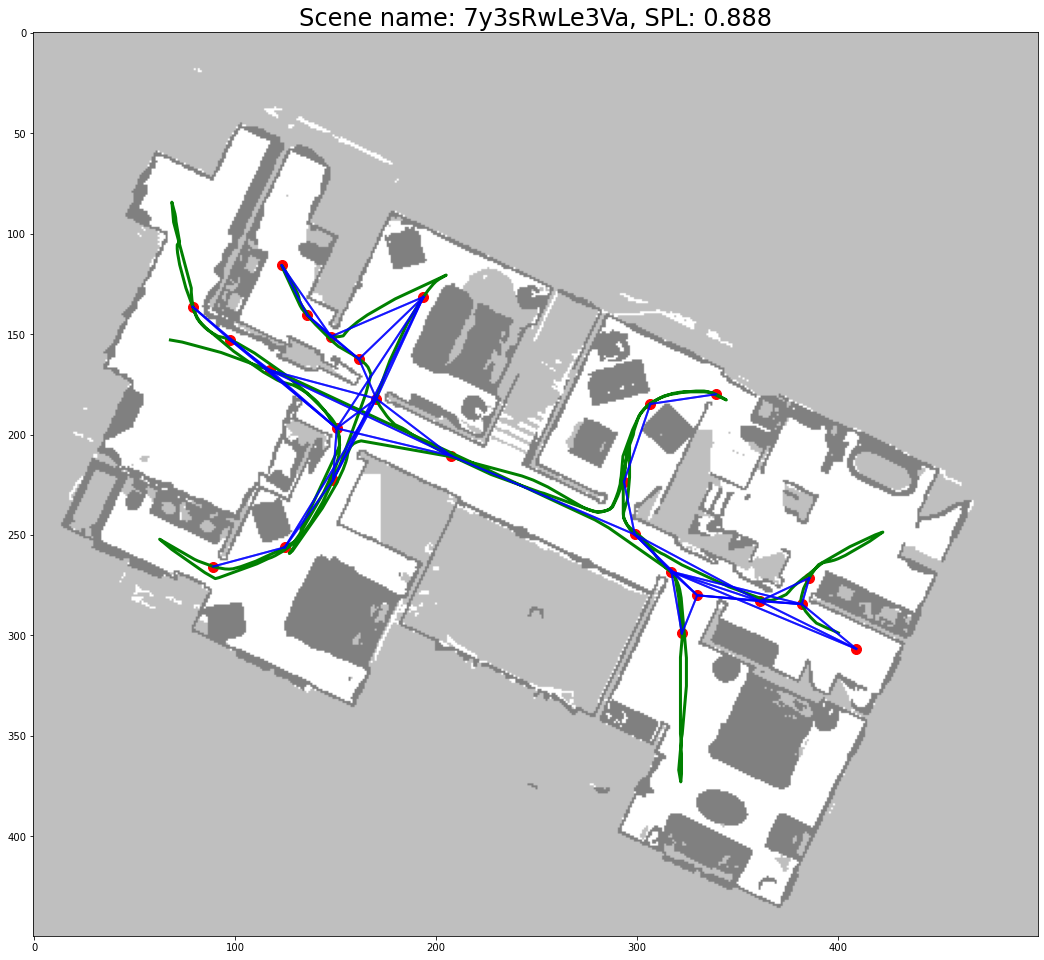

<ipython-input-8-6b6958457a5c>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(N)):


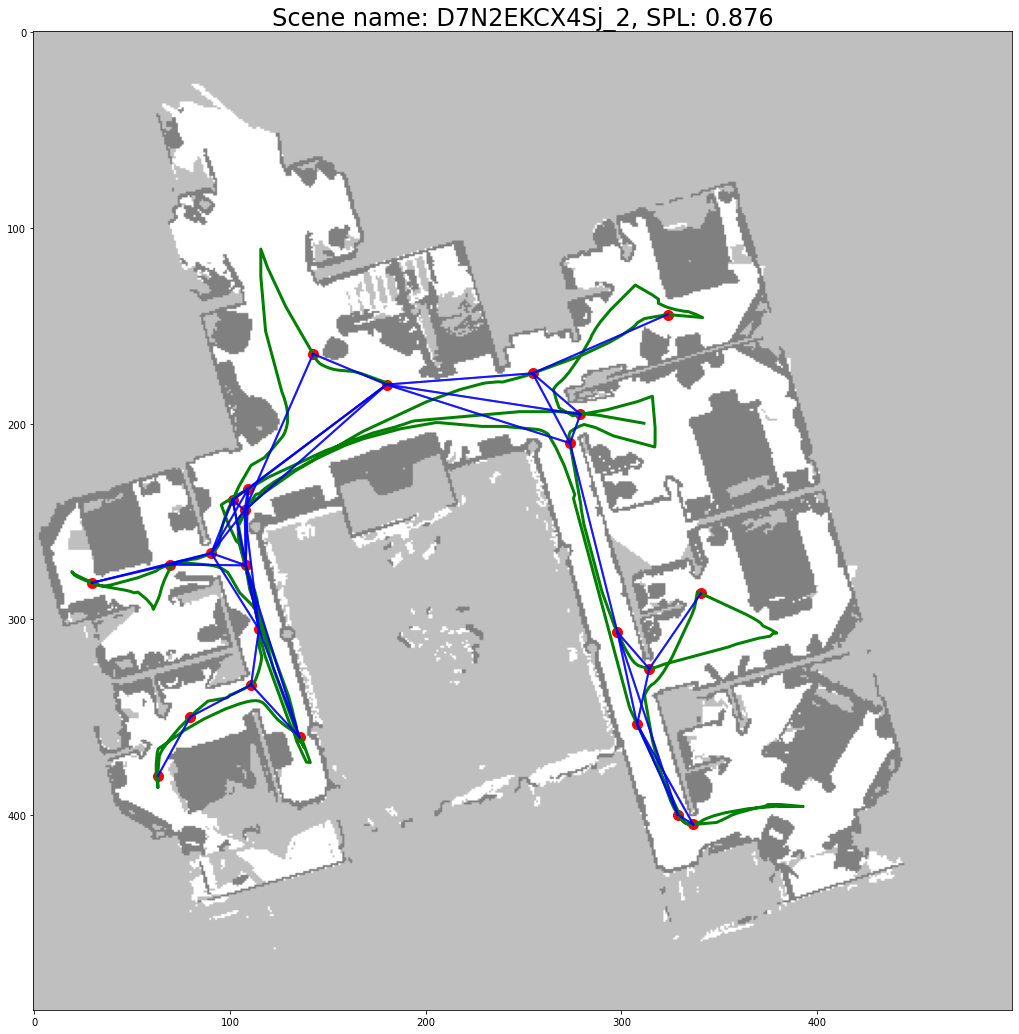

<ipython-input-8-6b6958457a5c>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(N)):


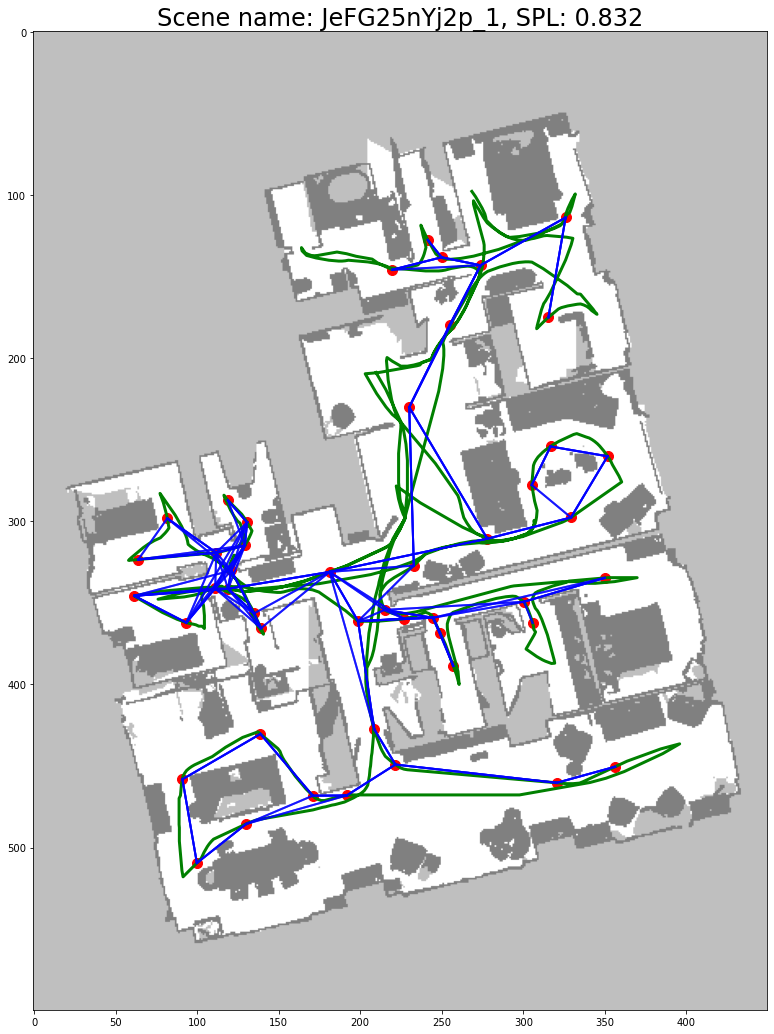

<ipython-input-8-6b6958457a5c>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(N)):


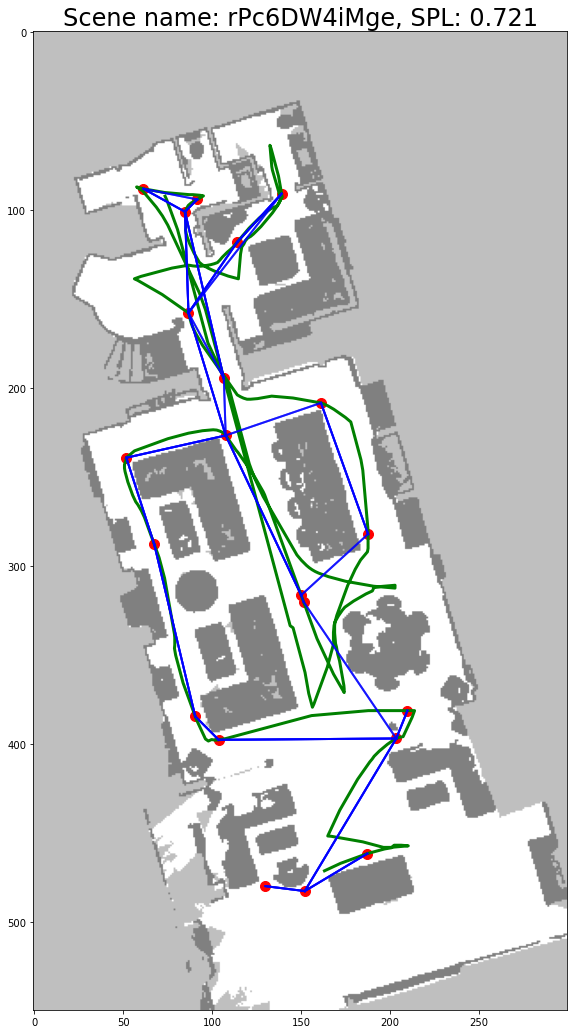

In [11]:
#scene_name = '2n8kARJN3HM'
iou_threshold = 0.25
scene_names = os.listdir('/home/kirill/TopoSLAM/GT')
scene_names.sort(key=lambda s: s.capitalize())
for scene_name in scene_names[1::4]:
    gt_map_dir = '/home/kirill/TopoSLAM/GT/{}'.format(scene_name)
    gt_map_filename = [x for x in os.listdir(gt_map_dir) if x.startswith('map_cropped_')][0]
    gt_map_file = os.path.join(gt_map_dir, gt_map_filename)
    gt_map = GTMap(gt_map_file)
    gt_map_image = imread(gt_map_file)
    graph = TopologicalGraph()
    path_to_json = '/home/kirill/TopoSLAM/toposlam_ws/src/simple_toposlam_model/graph_jsons_new/{}_{}.json'.format(scene_name, iou_threshold)
    graph.load_from_json(path_to_json)
    positions = np.loadtxt('/home/kirill/TopoSLAM/IncrementalTopo/experiment1_large_noise/{}/positions.txt'.format(scene_name))
    i = positions.shape[0] - 1
    while i > 0 and (positions[i] == positions[i - 1]).all():
        i -= 1
    positions = positions[:i]
    positions_ij = positions * 20 + 480 - [gt_map.start_j, gt_map.start_i]
    spl = get_spl(graph, gt_map, positions)
    
    plt.figure(figsize=(18, 18))
    plt.imshow(gt_map_image, cmap='gray', alpha=0.5)
    for x, y, theta in graph.vertices:
        i = y * 20 + 480 - gt_map.start_i
        j = x * 20 + 480 - gt_map.start_j
        plt.scatter([j], [i], color='r', s=100)
    plt.plot(positions_ij[:, 0], positions_ij[:, 1], color='g', lw=3)
    for u in range(len(graph.adj_lists)):
        for v, _, __ in graph.adj_lists[u]:
            x1, y1, theta = graph.vertices[u]
            x2, y2, theta = graph.vertices[v]
            i1 = y1 * 20 + 480 - gt_map.start_i
            j1 = x1 * 20 + 480 - gt_map.start_j
            i2 = y2 * 20 + 480 - gt_map.start_i
            j2 = x2 * 20 + 480 - gt_map.start_j
            plt.plot([j1, j2], [i1, i2], color='b', lw=2, alpha=0.7)
    plt.title('Scene name: {}, SPL: {}'.format(scene_name, np.round(spl, 3)), fontsize=24)
    plt.savefig('graph_pics/{}_0.25.png'.format(scene_name))
    plt.show()

In [ ]:
spl